In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\Sumo_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:0]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.3),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.002
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [4]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [5]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [6]:
batch_size=256

In [7]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [8]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [9]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [10]:
prediction_result_cv = []
prediction_result_ind = []

In [11]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH')

In [12]:
out = os.getcwd() + '\\'

In [29]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0   


Epoch 00029: val_loss did not improve from 0.56609
Epoch 30/300
8/8 - 0s - loss: 0.4757 - accuracy: 0.7721 - val_loss: 0.5894 - val_accuracy: 0.6622

Epoch 00030: val_loss did not improve from 0.56609
Epoch 31/300
8/8 - 0s - loss: 0.4595 - accuracy: 0.7716 - val_loss: 0.5710 - val_accuracy: 0.6978

Epoch 00031: val_loss did not improve from 0.56609
Epoch 32/300
8/8 - 0s - loss: 0.4869 - accuracy: 0.7612 - val_loss: 0.5835 - val_accuracy: 0.7067

Epoch 00032: val_loss did not improve from 0.56609
Epoch 33/300
8/8 - 0s - loss: 0.4475 - accuracy: 0.7949 - val_loss: 0.6134 - val_accuracy: 0.6400

Epoch 00033: val_loss did not improve from 0.56609
Epoch 34/300
8/8 - 0s - loss: 0.4659 - accuracy: 0.7815 - val_loss: 0.5693 - val_accuracy: 0.7067

Epoch 00034: val_loss did not improve from 0.56609
Epoch 35/300
8/8 - 0s - loss: 0.4455 - accuracy: 0.7944 - val_loss: 0.5652 - val_accuracy: 0.7111

Epoch 00035: val_loss improved from 0.56609 to 0.56525, saving model to D:\PycharmProjects\pythonPr

8/8 - 0s - loss: 0.2629 - accuracy: 0.8898 - val_loss: 0.6247 - val_accuracy: 0.6933

Epoch 00082: val_loss did not improve from 0.55255
Epoch 83/300
8/8 - 0s - loss: 0.2835 - accuracy: 0.8878 - val_loss: 0.5835 - val_accuracy: 0.7156

Epoch 00083: val_loss did not improve from 0.55255
Epoch 84/300
8/8 - 0s - loss: 0.2868 - accuracy: 0.8739 - val_loss: 0.6573 - val_accuracy: 0.6267

Epoch 00084: val_loss did not improve from 0.55255
Epoch 85/300
8/8 - 0s - loss: 0.2592 - accuracy: 0.8848 - val_loss: 0.6248 - val_accuracy: 0.6844

Epoch 00085: val_loss did not improve from 0.55255
Epoch 86/300
8/8 - 0s - loss: 0.2943 - accuracy: 0.8794 - val_loss: 0.6192 - val_accuracy: 0.6800

Epoch 00086: val_loss did not improve from 0.55255
Epoch 87/300
8/8 - 0s - loss: 0.2511 - accuracy: 0.8942 - val_loss: 0.5938 - val_accuracy: 0.7022

Epoch 00087: val_loss did not improve from 0.55255
Epoch 88/300
8/8 - 0s - loss: 0.2795 - accuracy: 0.8794 - val_loss: 0.5742 - val_accuracy: 0.7244

Epoch 00088: v

8/8 - 0s - loss: 0.5768 - accuracy: 0.6901 - val_loss: 0.5956 - val_accuracy: 0.7333

Epoch 00010: val_loss did not improve from 0.59086
Epoch 11/300
8/8 - 0s - loss: 0.5516 - accuracy: 0.7187 - val_loss: 0.5832 - val_accuracy: 0.7511

Epoch 00011: val_loss improved from 0.59086 to 0.58317, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_1.h5
Epoch 12/300
8/8 - 0s - loss: 0.5542 - accuracy: 0.7084 - val_loss: 0.5786 - val_accuracy: 0.7244

Epoch 00012: val_loss improved from 0.58317 to 0.57859, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_1.h5
Epoch 13/300
8/8 - 0s - loss: 0.5536 - accuracy: 0.6950 - val_loss: 0.5864 - val_accuracy: 0.7067

Epoch 00013: val_loss did not improve from 0.57859
Epoch 14/300
8/8 - 0s - loss: 0.5478 - accuracy: 0.7138 - val_loss: 0.5835 - val_accuracy: 0.6800

Epoch 00014: val_loss did not improve from 0.57859
Epoch 15/300
8/8 

8/8 - 0s - loss: 0.3568 - accuracy: 0.8473 - val_loss: 0.5487 - val_accuracy: 0.7244

Epoch 00059: val_loss did not improve from 0.53687
Epoch 60/300
8/8 - 0s - loss: 0.3307 - accuracy: 0.8611 - val_loss: 0.5489 - val_accuracy: 0.7422

Epoch 00060: val_loss did not improve from 0.53687
Epoch 61/300
8/8 - 0s - loss: 0.4026 - accuracy: 0.8206 - val_loss: 0.5640 - val_accuracy: 0.7333

Epoch 00061: val_loss did not improve from 0.53687
Epoch 62/300
8/8 - 0s - loss: 0.3241 - accuracy: 0.8601 - val_loss: 0.5918 - val_accuracy: 0.6800

Epoch 00062: val_loss did not improve from 0.53687
Epoch 63/300
8/8 - 0s - loss: 0.3395 - accuracy: 0.8552 - val_loss: 0.5608 - val_accuracy: 0.6933

Epoch 00063: val_loss did not improve from 0.53687
Epoch 64/300
8/8 - 0s - loss: 0.3442 - accuracy: 0.8473 - val_loss: 0.5681 - val_accuracy: 0.7378

Epoch 00064: val_loss did not improve from 0.53687
Epoch 65/300
8/8 - 0s - loss: 0.3644 - accuracy: 0.8389 - val_loss: 0.5468 - val_accuracy: 0.7333

Epoch 00065: v

8/8 - 0s - loss: 0.1815 - accuracy: 0.9333 - val_loss: 0.5373 - val_accuracy: 0.7422

Epoch 00113: val_loss did not improve from 0.53379
Epoch 114/300
8/8 - 0s - loss: 0.2221 - accuracy: 0.9046 - val_loss: 0.5493 - val_accuracy: 0.7378

Epoch 00114: val_loss did not improve from 0.53379
Epoch 115/300
8/8 - 0s - loss: 0.1880 - accuracy: 0.9273 - val_loss: 0.5288 - val_accuracy: 0.7467

Epoch 00115: val_loss improved from 0.53379 to 0.52882, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_1.h5
Epoch 116/300
8/8 - 0s - loss: 0.2501 - accuracy: 0.9011 - val_loss: 0.6277 - val_accuracy: 0.6933

Epoch 00116: val_loss did not improve from 0.52882
Epoch 117/300
8/8 - 0s - loss: 0.1989 - accuracy: 0.9204 - val_loss: 0.5439 - val_accuracy: 0.7244

Epoch 00117: val_loss did not improve from 0.52882
Epoch 118/300
8/8 - 0s - loss: 0.1923 - accuracy: 0.9174 - val_loss: 0.6365 - val_accuracy: 0.6933

Epoch 00118: val_loss did not improv

8/8 - 1s - loss: 0.6764 - accuracy: 0.5645 - val_loss: 0.6680 - val_accuracy: 0.5778

Epoch 00001: val_loss improved from inf to 0.66804, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_2.h5
Epoch 2/300
8/8 - 0s - loss: 0.6547 - accuracy: 0.6031 - val_loss: 0.6633 - val_accuracy: 0.5600

Epoch 00002: val_loss improved from 0.66804 to 0.66334, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_2.h5
Epoch 3/300
8/8 - 0s - loss: 0.6156 - accuracy: 0.6500 - val_loss: 0.6376 - val_accuracy: 0.6222

Epoch 00003: val_loss improved from 0.66334 to 0.63758, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_2.h5
Epoch 4/300
8/8 - 0s - loss: 0.6130 - accuracy: 0.6579 - val_loss: 0.6295 - val_accuracy: 0.6489

Epoch 00004: val_loss improved from 0.63758 to 0.62945, saving model to D:\PycharmProjects\pythonProje

8/8 - 0s - loss: 0.3853 - accuracy: 0.8309 - val_loss: 0.6101 - val_accuracy: 0.6889

Epoch 00046: val_loss did not improve from 0.58809
Epoch 47/300
8/8 - 0s - loss: 0.3888 - accuracy: 0.8265 - val_loss: 0.6107 - val_accuracy: 0.6800

Epoch 00047: val_loss did not improve from 0.58809
Epoch 48/300
8/8 - 0s - loss: 0.4056 - accuracy: 0.8122 - val_loss: 0.5828 - val_accuracy: 0.6978

Epoch 00048: val_loss improved from 0.58809 to 0.58284, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_2.h5
Epoch 49/300
8/8 - 0s - loss: 0.3859 - accuracy: 0.8220 - val_loss: 0.5864 - val_accuracy: 0.6622

Epoch 00049: val_loss did not improve from 0.58284
Epoch 50/300
8/8 - 0s - loss: 0.3969 - accuracy: 0.8211 - val_loss: 0.5890 - val_accuracy: 0.6667

Epoch 00050: val_loss did not improve from 0.58284
Epoch 51/300
8/8 - 0s - loss: 0.3597 - accuracy: 0.8339 - val_loss: 0.6469 - val_accuracy: 0.6356

Epoch 00051: val_loss did not improve fro

conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)           147584    
__________


Epoch 00029: val_loss improved from 0.53449 to 0.53388, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_3.h5
Epoch 30/300
8/8 - 0s - loss: 0.4811 - accuracy: 0.7573 - val_loss: 0.5394 - val_accuracy: 0.7644

Epoch 00030: val_loss did not improve from 0.53388
Epoch 31/300
8/8 - 0s - loss: 0.4638 - accuracy: 0.7706 - val_loss: 0.5652 - val_accuracy: 0.6889

Epoch 00031: val_loss did not improve from 0.53388
Epoch 32/300
8/8 - 0s - loss: 0.4858 - accuracy: 0.7568 - val_loss: 0.5469 - val_accuracy: 0.7422

Epoch 00032: val_loss did not improve from 0.53388
Epoch 33/300
8/8 - 0s - loss: 0.4745 - accuracy: 0.7721 - val_loss: 0.5401 - val_accuracy: 0.7733

Epoch 00033: val_loss did not improve from 0.53388
Epoch 34/300
8/8 - 0s - loss: 0.4646 - accuracy: 0.7721 - val_loss: 0.5204 - val_accuracy: 0.7689

Epoch 00034: val_loss improved from 0.53388 to 0.52042, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetr


Epoch 00078: val_loss did not improve from 0.49878
Epoch 79/300
8/8 - 0s - loss: 0.3054 - accuracy: 0.8651 - val_loss: 0.5050 - val_accuracy: 0.7556

Epoch 00079: val_loss did not improve from 0.49878
Epoch 80/300
8/8 - 0s - loss: 0.2925 - accuracy: 0.8705 - val_loss: 0.4986 - val_accuracy: 0.7689

Epoch 00080: val_loss improved from 0.49878 to 0.49861, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_3.h5
Epoch 81/300
8/8 - 0s - loss: 0.2858 - accuracy: 0.8794 - val_loss: 0.5564 - val_accuracy: 0.7067

Epoch 00081: val_loss did not improve from 0.49861
Epoch 82/300
8/8 - 0s - loss: 0.2985 - accuracy: 0.8725 - val_loss: 0.5032 - val_accuracy: 0.7511

Epoch 00082: val_loss did not improve from 0.49861
Epoch 83/300
8/8 - 0s - loss: 0.3118 - accuracy: 0.8636 - val_loss: 0.5255 - val_accuracy: 0.7689

Epoch 00083: val_loss did not improve from 0.49861
Epoch 84/300
8/8 - 0s - loss: 0.2648 - accuracy: 0.8908 - val_loss: 0.5567 

8/8 - 0s - loss: 0.2274 - accuracy: 0.9081 - val_loss: 0.4980 - val_accuracy: 0.7867

Epoch 00130: val_loss did not improve from 0.48926
Epoch 131/300
8/8 - 0s - loss: 0.2146 - accuracy: 0.9170 - val_loss: 0.5037 - val_accuracy: 0.7733

Epoch 00131: val_loss did not improve from 0.48926
Epoch 132/300
8/8 - 0s - loss: 0.1874 - accuracy: 0.9204 - val_loss: 0.5417 - val_accuracy: 0.7378

Epoch 00132: val_loss did not improve from 0.48926
Epoch 133/300
8/8 - 0s - loss: 0.1782 - accuracy: 0.9273 - val_loss: 0.5201 - val_accuracy: 0.7644

Epoch 00133: val_loss did not improve from 0.48926
Epoch 134/300
8/8 - 0s - loss: 0.2100 - accuracy: 0.9209 - val_loss: 0.5380 - val_accuracy: 0.7467

Epoch 00134: val_loss did not improve from 0.48926
Epoch 135/300
8/8 - 0s - loss: 0.1812 - accuracy: 0.9204 - val_loss: 0.5729 - val_accuracy: 0.7333

Epoch 00135: val_loss did not improve from 0.48926
Epoch 136/300
8/8 - 0s - loss: 0.1907 - accuracy: 0.9229 - val_loss: 0.5410 - val_accuracy: 0.7156

Epoch 00

8/8 - 0s - loss: 0.5713 - accuracy: 0.6980 - val_loss: 0.6041 - val_accuracy: 0.6444

Epoch 00008: val_loss improved from 0.61016 to 0.60406, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_4.h5
Epoch 9/300
8/8 - 0s - loss: 0.5683 - accuracy: 0.7084 - val_loss: 0.6165 - val_accuracy: 0.6356

Epoch 00009: val_loss did not improve from 0.60406
Epoch 10/300
8/8 - 0s - loss: 0.5567 - accuracy: 0.7014 - val_loss: 0.5997 - val_accuracy: 0.6489

Epoch 00010: val_loss improved from 0.60406 to 0.59974, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_4.h5
Epoch 11/300
8/8 - 0s - loss: 0.5820 - accuracy: 0.6876 - val_loss: 0.6004 - val_accuracy: 0.6533

Epoch 00011: val_loss did not improve from 0.59974
Epoch 12/300
8/8 - 0s - loss: 0.5530 - accuracy: 0.7182 - val_loss: 0.6115 - val_accuracy: 0.6444

Epoch 00012: val_loss did not improve from 0.59974
Epoch 13/300
8/8 -


Epoch 00058: val_loss did not improve from 0.58900
Epoch 59/300
8/8 - 0s - loss: 0.3478 - accuracy: 0.8478 - val_loss: 0.6083 - val_accuracy: 0.6756

Epoch 00059: val_loss did not improve from 0.58900
Epoch 60/300
8/8 - 0s - loss: 0.3326 - accuracy: 0.8517 - val_loss: 0.6273 - val_accuracy: 0.6578

Epoch 00060: val_loss did not improve from 0.58900
Epoch 61/300
8/8 - 0s - loss: 0.3795 - accuracy: 0.8275 - val_loss: 0.5926 - val_accuracy: 0.6667

Epoch 00061: val_loss did not improve from 0.58900
Epoch 62/300
8/8 - 0s - loss: 0.3394 - accuracy: 0.8482 - val_loss: 0.6133 - val_accuracy: 0.6622

Epoch 00062: val_loss did not improve from 0.58900
Epoch 63/300
8/8 - 0s - loss: 0.3124 - accuracy: 0.8705 - val_loss: 0.5977 - val_accuracy: 0.6622

Epoch 00063: val_loss did not improve from 0.58900
Epoch 64/300
8/8 - 0s - loss: 0.3556 - accuracy: 0.8379 - val_loss: 0.5986 - val_accuracy: 0.6444

Epoch 00064: val_loss did not improve from 0.58900
Epoch 65/300
8/8 - 0s - loss: 0.3324 - accuracy:


Epoch 00112: val_loss did not improve from 0.58767
Epoch 113/300
8/8 - 0s - loss: 0.2254 - accuracy: 0.9021 - val_loss: 0.7128 - val_accuracy: 0.6178

Epoch 00113: val_loss did not improve from 0.58767
Epoch 114/300
8/8 - 0s - loss: 0.2090 - accuracy: 0.9140 - val_loss: 0.6102 - val_accuracy: 0.6889

Epoch 00114: val_loss did not improve from 0.58767
Epoch 115/300
8/8 - 0s - loss: 0.2102 - accuracy: 0.9155 - val_loss: 0.6694 - val_accuracy: 0.6489

Epoch 00115: val_loss did not improve from 0.58767
5
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
______________

8/8 - 0s - loss: 0.5189 - accuracy: 0.7281 - val_loss: 0.5643 - val_accuracy: 0.7333

Epoch 00023: val_loss improved from 0.56679 to 0.56433, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_5.h5
Epoch 24/300
8/8 - 0s - loss: 0.5119 - accuracy: 0.7390 - val_loss: 0.5720 - val_accuracy: 0.7333

Epoch 00024: val_loss did not improve from 0.56433
Epoch 25/300
8/8 - 0s - loss: 0.5226 - accuracy: 0.7326 - val_loss: 0.5768 - val_accuracy: 0.7156

Epoch 00025: val_loss did not improve from 0.56433
Epoch 26/300
8/8 - 0s - loss: 0.4955 - accuracy: 0.7553 - val_loss: 0.5782 - val_accuracy: 0.7067

Epoch 00026: val_loss did not improve from 0.56433
Epoch 27/300
8/8 - 0s - loss: 0.4966 - accuracy: 0.7484 - val_loss: 0.5774 - val_accuracy: 0.7244

Epoch 00027: val_loss did not improve from 0.56433
Epoch 28/300
8/8 - 0s - loss: 0.4640 - accuracy: 0.7785 - val_loss: 0.5712 - val_accuracy: 0.7244

Epoch 00028: val_loss did not improve fro


Epoch 00073: val_loss did not improve from 0.54421
Epoch 74/300
8/8 - 0s - loss: 0.3286 - accuracy: 0.8517 - val_loss: 0.5581 - val_accuracy: 0.7244

Epoch 00074: val_loss did not improve from 0.54421
Epoch 75/300
8/8 - 0s - loss: 0.2945 - accuracy: 0.8730 - val_loss: 0.5756 - val_accuracy: 0.7244

Epoch 00075: val_loss did not improve from 0.54421
Epoch 76/300
8/8 - 0s - loss: 0.2749 - accuracy: 0.8804 - val_loss: 0.5568 - val_accuracy: 0.7378

Epoch 00076: val_loss did not improve from 0.54421
Epoch 77/300
8/8 - 0s - loss: 0.3283 - accuracy: 0.8507 - val_loss: 0.5715 - val_accuracy: 0.7067

Epoch 00077: val_loss did not improve from 0.54421
Epoch 78/300
8/8 - 0s - loss: 0.2609 - accuracy: 0.8937 - val_loss: 0.5651 - val_accuracy: 0.7467

Epoch 00078: val_loss did not improve from 0.54421
Epoch 79/300
8/8 - 0s - loss: 0.2888 - accuracy: 0.8670 - val_loss: 0.6178 - val_accuracy: 0.6889

Epoch 00079: val_loss did not improve from 0.54421
Epoch 80/300
8/8 - 0s - loss: 0.3057 - accuracy:

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_7 (Functional)         (None, 5, 128)            199680    
_________________________________________________________________
dense_14 (Dense)             (None, 5, 64)             8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_7 ( (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6904 - accuracy: 0.5378 - val_loss: 0.6470 - val_accuracy: 0.6267

Epoch 00001: val

8/8 - 0s - loss: 0.4894 - accuracy: 0.7756 - val_loss: 0.5639 - val_accuracy: 0.7067

Epoch 00039: val_loss did not improve from 0.54332
Epoch 40/300
8/8 - 0s - loss: 0.4078 - accuracy: 0.8092 - val_loss: 0.5530 - val_accuracy: 0.7111

Epoch 00040: val_loss did not improve from 0.54332
Epoch 41/300
8/8 - 0s - loss: 0.4335 - accuracy: 0.7944 - val_loss: 0.5473 - val_accuracy: 0.7067

Epoch 00041: val_loss did not improve from 0.54332
Epoch 42/300
8/8 - 0s - loss: 0.4393 - accuracy: 0.7874 - val_loss: 0.5608 - val_accuracy: 0.7111

Epoch 00042: val_loss did not improve from 0.54332
Epoch 43/300
8/8 - 0s - loss: 0.4188 - accuracy: 0.8038 - val_loss: 0.5766 - val_accuracy: 0.6800

Epoch 00043: val_loss did not improve from 0.54332
Epoch 44/300
8/8 - 0s - loss: 0.4379 - accuracy: 0.7904 - val_loss: 0.5634 - val_accuracy: 0.6933

Epoch 00044: val_loss did not improve from 0.54332
Epoch 45/300
8/8 - 0s - loss: 0.4259 - accuracy: 0.8072 - val_loss: 0.5607 - val_accuracy: 0.7111

Epoch 00045: v

8/8 - 1s - loss: 0.6691 - accuracy: 0.5744 - val_loss: 0.6437 - val_accuracy: 0.6756

Epoch 00001: val_loss improved from inf to 0.64371, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_7.h5
Epoch 2/300
8/8 - 0s - loss: 0.6487 - accuracy: 0.6273 - val_loss: 0.6319 - val_accuracy: 0.6667

Epoch 00002: val_loss improved from 0.64371 to 0.63190, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_7.h5
Epoch 3/300
8/8 - 0s - loss: 0.6088 - accuracy: 0.6550 - val_loss: 0.6128 - val_accuracy: 0.6800

Epoch 00003: val_loss improved from 0.63190 to 0.61282, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_7.h5
Epoch 4/300
8/8 - 0s - loss: 0.6035 - accuracy: 0.6619 - val_loss: 0.6041 - val_accuracy: 0.6711

Epoch 00004: val_loss improved from 0.61282 to 0.60414, saving model to D:\PycharmProjects\pythonProje


Epoch 00044: val_loss did not improve from 0.53100
Epoch 45/300
8/8 - 0s - loss: 0.4197 - accuracy: 0.8013 - val_loss: 0.5851 - val_accuracy: 0.6756

Epoch 00045: val_loss did not improve from 0.53100
Epoch 46/300
8/8 - 0s - loss: 0.4013 - accuracy: 0.8136 - val_loss: 0.5400 - val_accuracy: 0.7333

Epoch 00046: val_loss did not improve from 0.53100
Epoch 47/300
8/8 - 0s - loss: 0.4075 - accuracy: 0.8161 - val_loss: 0.5439 - val_accuracy: 0.7022

Epoch 00047: val_loss did not improve from 0.53100
Epoch 48/300
8/8 - 0s - loss: 0.4110 - accuracy: 0.8146 - val_loss: 0.5457 - val_accuracy: 0.6933

Epoch 00048: val_loss did not improve from 0.53100
Epoch 49/300
8/8 - 0s - loss: 0.3971 - accuracy: 0.8216 - val_loss: 0.5989 - val_accuracy: 0.6800

Epoch 00049: val_loss did not improve from 0.53100
Epoch 50/300
8/8 - 0s - loss: 0.4023 - accuracy: 0.8117 - val_loss: 0.5392 - val_accuracy: 0.7200

Epoch 00050: val_loss did not improve from 0.53100
Epoch 51/300
8/8 - 0s - loss: 0.4102 - accuracy:


Epoch 00098: val_loss did not improve from 0.53087
Epoch 99/300
8/8 - 0s - loss: 0.2543 - accuracy: 0.8952 - val_loss: 0.5517 - val_accuracy: 0.7156

Epoch 00099: val_loss did not improve from 0.53087
Epoch 100/300
8/8 - 0s - loss: 0.2277 - accuracy: 0.9016 - val_loss: 0.5474 - val_accuracy: 0.7289

Epoch 00100: val_loss did not improve from 0.53087
Epoch 101/300
8/8 - 0s - loss: 0.2218 - accuracy: 0.9090 - val_loss: 0.6036 - val_accuracy: 0.6978

Epoch 00101: val_loss did not improve from 0.53087
Epoch 102/300
8/8 - 0s - loss: 0.2324 - accuracy: 0.9021 - val_loss: 0.5975 - val_accuracy: 0.7067

Epoch 00102: val_loss did not improve from 0.53087
Epoch 103/300
8/8 - 0s - loss: 0.2348 - accuracy: 0.8997 - val_loss: 0.5734 - val_accuracy: 0.7156

Epoch 00103: val_loss did not improve from 0.53087
Epoch 104/300
8/8 - 0s - loss: 0.2512 - accuracy: 0.8947 - val_loss: 0.5400 - val_accuracy: 0.7289

Epoch 00104: val_loss did not improve from 0.53087
Epoch 105/300
8/8 - 0s - loss: 0.2252 - acc


Epoch 00009: val_loss improved from 0.58856 to 0.58565, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_8.h5
Epoch 10/300
8/8 - 0s - loss: 0.5759 - accuracy: 0.6976 - val_loss: 0.5891 - val_accuracy: 0.7098

Epoch 00010: val_loss did not improve from 0.58565
Epoch 11/300
8/8 - 0s - loss: 0.5560 - accuracy: 0.7036 - val_loss: 0.5804 - val_accuracy: 0.6652

Epoch 00011: val_loss improved from 0.58565 to 0.58040, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_8.h5
Epoch 12/300
8/8 - 0s - loss: 0.5398 - accuracy: 0.7125 - val_loss: 0.5773 - val_accuracy: 0.6920

Epoch 00012: val_loss improved from 0.58040 to 0.57731, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_8.h5
Epoch 13/300
8/8 - 0s - loss: 0.5606 - accuracy: 0.7090 - val_loss: 0.5822 - val_accuracy: 0.7232

Epoch 00013: val_loss did not 


Epoch 00054: val_loss did not improve from 0.54416
Epoch 55/300
8/8 - 0s - loss: 0.3725 - accuracy: 0.8330 - val_loss: 0.5568 - val_accuracy: 0.7232

Epoch 00055: val_loss did not improve from 0.54416
Epoch 56/300
8/8 - 0s - loss: 0.3449 - accuracy: 0.8523 - val_loss: 0.5691 - val_accuracy: 0.7143

Epoch 00056: val_loss did not improve from 0.54416
Epoch 57/300
8/8 - 0s - loss: 0.3539 - accuracy: 0.8528 - val_loss: 0.5808 - val_accuracy: 0.7232

Epoch 00057: val_loss did not improve from 0.54416
Epoch 58/300
8/8 - 0s - loss: 0.3816 - accuracy: 0.8221 - val_loss: 0.5837 - val_accuracy: 0.6786

Epoch 00058: val_loss did not improve from 0.54416
Epoch 59/300
8/8 - 0s - loss: 0.3377 - accuracy: 0.8557 - val_loss: 0.5562 - val_accuracy: 0.7098

Epoch 00059: val_loss did not improve from 0.54416
Epoch 60/300
8/8 - 0s - loss: 0.4016 - accuracy: 0.8137 - val_loss: 0.5691 - val_accuracy: 0.7188

Epoch 00060: val_loss did not improve from 0.54416
Epoch 61/300
8/8 - 0s - loss: 0.3174 - accuracy:


Epoch 00107: val_loss did not improve from 0.53839
Epoch 108/300
8/8 - 0s - loss: 0.2536 - accuracy: 0.8928 - val_loss: 0.5821 - val_accuracy: 0.7277

Epoch 00108: val_loss did not improve from 0.53839
Epoch 109/300
8/8 - 0s - loss: 0.1957 - accuracy: 0.9244 - val_loss: 0.5783 - val_accuracy: 0.7277

Epoch 00109: val_loss did not improve from 0.53839
Epoch 110/300
8/8 - 0s - loss: 0.2145 - accuracy: 0.9160 - val_loss: 0.5833 - val_accuracy: 0.6964

Epoch 00110: val_loss did not improve from 0.53839
Epoch 111/300
8/8 - 0s - loss: 0.2248 - accuracy: 0.9012 - val_loss: 0.5732 - val_accuracy: 0.7009

Epoch 00111: val_loss did not improve from 0.53839
Epoch 112/300
8/8 - 0s - loss: 0.2057 - accuracy: 0.9160 - val_loss: 0.6020 - val_accuracy: 0.7009

Epoch 00112: val_loss did not improve from 0.53839
Epoch 113/300
8/8 - 0s - loss: 0.1993 - accuracy: 0.9180 - val_loss: 0.6077 - val_accuracy: 0.7277

Epoch 00113: val_loss did not improve from 0.53839
Epoch 114/300
8/8 - 0s - loss: 0.1965 - ac


Epoch 00012: val_loss improved from 0.59150 to 0.57921, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_9.h5
Epoch 13/300
8/8 - 0s - loss: 0.5679 - accuracy: 0.6981 - val_loss: 0.5994 - val_accuracy: 0.6786

Epoch 00013: val_loss did not improve from 0.57921
Epoch 14/300
8/8 - 0s - loss: 0.5350 - accuracy: 0.7253 - val_loss: 0.5888 - val_accuracy: 0.6786

Epoch 00014: val_loss did not improve from 0.57921
Epoch 15/300
8/8 - 0s - loss: 0.5587 - accuracy: 0.7090 - val_loss: 0.6054 - val_accuracy: 0.6830

Epoch 00015: val_loss did not improve from 0.57921
Epoch 16/300
8/8 - 0s - loss: 0.5285 - accuracy: 0.7297 - val_loss: 0.5705 - val_accuracy: 0.7143

Epoch 00016: val_loss improved from 0.57921 to 0.57051, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\_9.h5
Epoch 17/300
8/8 - 0s - loss: 0.5139 - accuracy: 0.7342 - val_loss: 0.5942 - val_accuracy: 0.6830

Epo


Epoch 00061: val_loss did not improve from 0.55210
Epoch 62/300
8/8 - 0s - loss: 0.3591 - accuracy: 0.8345 - val_loss: 0.6253 - val_accuracy: 0.6964

Epoch 00062: val_loss did not improve from 0.55210
Epoch 63/300
8/8 - 0s - loss: 0.3420 - accuracy: 0.8523 - val_loss: 0.5960 - val_accuracy: 0.6696

Epoch 00063: val_loss did not improve from 0.55210
Epoch 64/300
8/8 - 0s - loss: 0.3272 - accuracy: 0.8523 - val_loss: 0.5879 - val_accuracy: 0.6786

Epoch 00064: val_loss did not improve from 0.55210
Epoch 65/300
8/8 - 0s - loss: 0.3522 - accuracy: 0.8483 - val_loss: 0.5752 - val_accuracy: 0.6696

Epoch 00065: val_loss did not improve from 0.55210
Epoch 66/300
8/8 - 0s - loss: 0.3279 - accuracy: 0.8518 - val_loss: 0.5800 - val_accuracy: 0.6786

Epoch 00066: val_loss did not improve from 0.55210
Epoch 67/300
8/8 - 0s - loss: 0.3309 - accuracy: 0.8552 - val_loss: 0.6095 - val_accuracy: 0.6741

Epoch 00067: val_loss did not improve from 0.55210
Epoch 68/300
8/8 - 0s - loss: 0.2834 - accuracy:

In [30]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [31]:
roc_auc_list_val

[0.7695164348925412,
 0.7727200255102041,
 0.7982774968394437,
 0.7370417193426042,
 0.8423672566371682,
 0.7458122629582807,
 0.7859513274336284,
 0.7620101137800254,
 0.8027022756005058,
 0.7794164540816326]

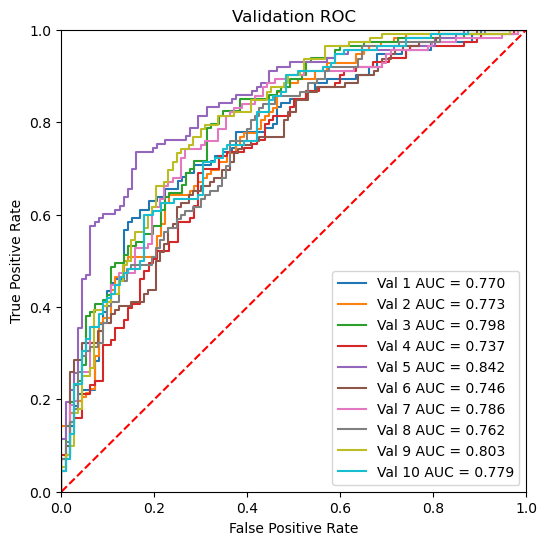

In [32]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

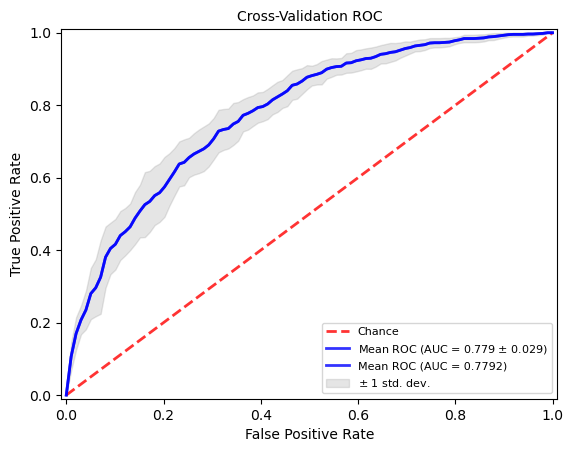

In [33]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [34]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [35]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [36]:
my_calculate_metrics_list_val

[{'SN': 0.7787610619469026,
  'SP': 0.5714285714285714,
  'ACC': 0.6755555555555556,
  'MCC': 0.3580857685533702,
  'Recall': 0.7787610619469026,
  'Precision': 0.6470588235294118,
  'F1-score': 0.7068273092369478,
  'Cutoff': 0.5},
 {'SN': 0.8035714285714286,
  'SP': 0.5714285714285714,
  'ACC': 0.6875,
  'MCC': 0.38553208016086654,
  'Recall': 0.8035714285714286,
  'Precision': 0.6521739130434783,
  'F1-score': 0.72,
  'Cutoff': 0.5},
 {'SN': 0.7433628318584071,
  'SP': 0.6875,
  'ACC': 0.7155555555555555,
  'MCC': 0.4315795434686004,
  'Recall': 0.7433628318584071,
  'Precision': 0.7058823529411765,
  'F1-score': 0.7241379310344828,
  'Cutoff': 0.5},
 {'SN': 0.7964601769911505,
  'SP': 0.5535714285714286,
  'ACC': 0.6755555555555556,
  'MCC': 0.36097906229491067,
  'Recall': 0.7964601769911505,
  'Precision': 0.6428571428571429,
  'F1-score': 0.7114624505928854,
  'Cutoff': 0.5},
 {'SN': 0.7610619469026548,
  'SP': 0.7321428571428571,
  'ACC': 0.7466666666666667,
  'MCC': 0.49343879

In [37]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.778761,0.571429,0.675556,0.358086,0.778761,0.647059,0.706827,0.5
1,0.803571,0.571429,0.687500,0.385532,0.803571,0.652174,0.720000,0.5
2,0.743363,0.687500,0.715556,0.431580,0.743363,0.705882,0.724138,0.5
3,0.796460,0.553571,0.675556,0.360979,0.796460,0.642857,0.711462,0.5
4,0.761062,0.732143,0.746667,0.493439,0.761062,0.741379,0.751092,0.5
5,0.500000,0.796460,0.648889,0.310545,0.500000,0.708861,0.586387,0.5
6,0.892857,0.513274,0.702222,0.438632,0.892857,0.645161,0.749064,0.5
7,0.821429,0.575221,0.697778,0.409055,0.821429,0.657143,0.730159,0.5
8,0.803571,0.663717,0.733333,0.471783,0.803571,0.703125,0.750000,0.5
9,0.723214,0.669643,0.696429,0.393422,0.723214,0.686441,0.704348,0.5


In [38]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.778761,0.571429,0.675556,0.358086,0.778761,0.647059,0.706827,0.5
1,0.803571,0.571429,0.687500,0.385532,0.803571,0.652174,0.720000,0.5
2,0.743363,0.687500,0.715556,0.431580,0.743363,0.705882,0.724138,0.5
3,0.796460,0.553571,0.675556,0.360979,0.796460,0.642857,0.711462,0.5
4,0.761062,0.732143,0.746667,0.493439,0.761062,0.741379,0.751092,0.5
5,0.500000,0.796460,0.648889,0.310545,0.500000,0.708861,0.586387,0.5
6,0.892857,0.513274,0.702222,0.438632,0.892857,0.645161,0.749064,0.5
7,0.821429,0.575221,0.697778,0.409055,0.821429,0.657143,0.730159,0.5
8,0.803571,0.663717,0.733333,0.471783,0.803571,0.703125,0.750000,0.5
9,0.723214,0.669643,0.696429,0.393422,0.723214,0.686441,0.704348,0.5


In [39]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [40]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [41]:
roc_auc_list_indep

[0.7798947704081632,
 0.7931281887755102,
 0.7921715561224489,
 0.783482142857143,
 0.7857142857142857,
 0.7877869897959183,
 0.7946428571428571,
 0.8044483418367347,
 0.8159279336734695,
 0.784279336734694]

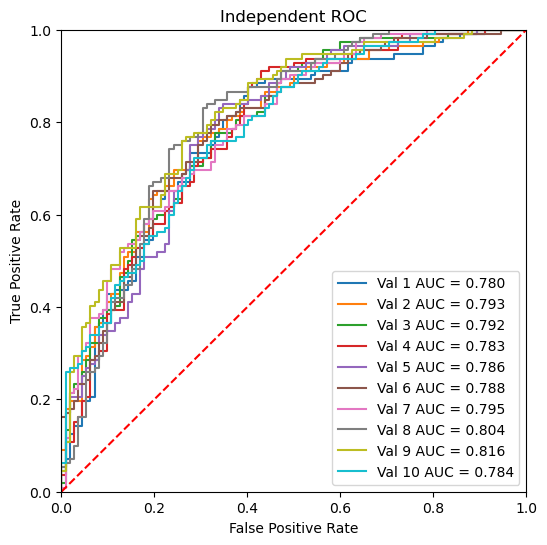

In [42]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

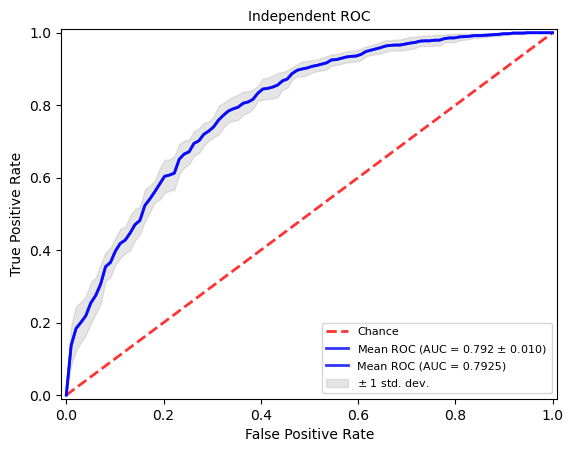

In [43]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [51]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [52]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [53]:
my_calculate_metrics_list_indep

[{'SN': 0.7410714285714286,
  'SP': 0.6964285714285714,
  'ACC': 0.71875,
  'MCC': 0.4379366181402369,
  'Recall': 0.7410714285714286,
  'Precision': 0.7094017094017094,
  'F1-score': 0.7248908296943232,
  'Cutoff': 0.5},
 {'SN': 0.8928571428571429,
  'SP': 0.5446428571428571,
  'ACC': 0.71875,
  'MCC': 0.4667090004687828,
  'Recall': 0.8928571428571429,
  'Precision': 0.6622516556291391,
  'F1-score': 0.7604562737642585,
  'Cutoff': 0.5},
 {'SN': 0.8125,
  'SP': 0.625,
  'ACC': 0.71875,
  'MCC': 0.44539933408304444,
  'Recall': 0.8125,
  'Precision': 0.6842105263157895,
  'F1-score': 0.7428571428571429,
  'Cutoff': 0.5},
 {'SN': 0.875,
  'SP': 0.5803571428571429,
  'ACC': 0.7276785714285714,
  'MCC': 0.4765106695111974,
  'Recall': 0.875,
  'Precision': 0.6758620689655173,
  'F1-score': 0.7626459143968871,
  'Cutoff': 0.5},
 {'SN': 0.625,
  'SP': 0.8125,
  'ACC': 0.71875,
  'MCC': 0.44539933408304444,
  'Recall': 0.625,
  'Precision': 0.7692307692307693,
  'F1-score': 0.68965517241379

In [54]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.741071,0.696429,0.718750,0.437937,0.741071,0.709402,0.724891,0.5
1,0.892857,0.544643,0.718750,0.466709,0.892857,0.662252,0.760456,0.5
2,0.812500,0.625000,0.718750,0.445399,0.812500,0.684211,0.742857,0.5
3,0.875000,0.580357,0.727679,0.476511,0.875000,0.675862,0.762646,0.5
4,0.625000,0.812500,0.718750,0.445399,0.625000,0.769231,0.689655,0.5
5,0.901786,0.428571,0.665179,0.375002,0.901786,0.612121,0.729242,0.5
6,0.767857,0.696429,0.732143,0.465475,0.767857,0.716667,0.741379,0.5
7,0.892857,0.580357,0.736607,0.498163,0.892857,0.680272,0.772201,0.5
8,0.705357,0.741071,0.723214,0.446714,0.705357,0.731481,0.718182,0.5
9,0.607143,0.794643,0.700893,0.409040,0.607143,0.747253,0.669951,0.5


In [55]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.741071,0.696429,0.718750,0.437937,0.741071,0.709402,0.724891,0.5
1,0.892857,0.544643,0.718750,0.466709,0.892857,0.662252,0.760456,0.5
2,0.812500,0.625000,0.718750,0.445399,0.812500,0.684211,0.742857,0.5
3,0.875000,0.580357,0.727679,0.476511,0.875000,0.675862,0.762646,0.5
4,0.625000,0.812500,0.718750,0.445399,0.625000,0.769231,0.689655,0.5
5,0.901786,0.428571,0.665179,0.375002,0.901786,0.612121,0.729242,0.5
6,0.767857,0.696429,0.732143,0.465475,0.767857,0.716667,0.741379,0.5
7,0.892857,0.580357,0.736607,0.498163,0.892857,0.680272,0.772201,0.5
8,0.705357,0.741071,0.723214,0.446714,0.705357,0.731481,0.718182,0.5
9,0.607143,0.794643,0.700893,0.409040,0.607143,0.747253,0.669951,0.5


In [56]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Sumo\try\CNN_OH\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

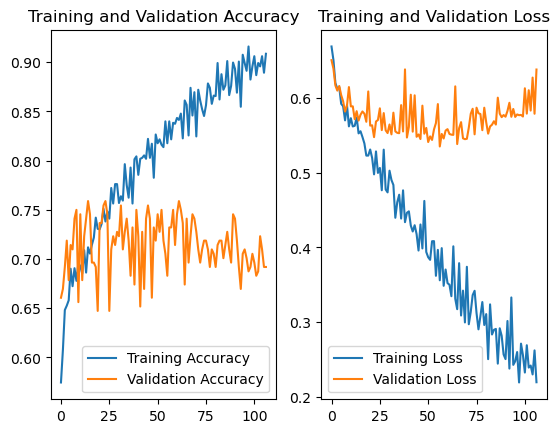

In [58]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()